# Overview
這一份程式分析

In [7]:
# 說明：設置環境、import 套件
import pandas as pd
import numpy as np
import pprint 
import matplotlib.pyplot as plt
from matplotlib import pylab
%pylab inline
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (20, 8)

Populating the interactive namespace from numpy and matplotlib


In [8]:
# color sets
cPurple = '#5628B4'
cLightPurple = '#9590D0'
cRed = '#D2553E'
cGreen = '#98B855'

In [9]:
import matplotlib.font_manager as fm 
myfont = fm.FontProperties( fname="/Library/Fonts/ヒラギノ丸ゴ ProN W4.ttc")   

In [10]:
# Global variables
CostRate = 2.4 # 一度電多少錢（估算，實際還要再確認）

### 原始資料說明 - 1
- 區間：去年 09/01 - 11/10，七一天
    - 這份資料區間以方便分析為主，所以 71 天只是 1.0 版本，之後會擴張到整學期
- 間隔：一小時一筆
- 地點：所有的學生宿舍，以下我是針對十二舍做
- 一個地點的筆數：每棟大樓共 71(day) * 24(hr) = 1704 筆
- 總筆數 = 1704 * 17 = 28968 筆

In [12]:
df = pd.read_csv('../01data/[new]D12_hr_20170831_20180228.csv') # 讀檔案
df.tail()

,Unnamed: 0,DateTime,Area,Building,Loop,Type,Usage,Date,Weekday,Time,Week,Cost(2.8)
4356,4356,2018/02/28 19:00,S,D12,main,dorm,107.5,2018-02-28,3,19:00,9,301.0
4357,4357,2018/02/28 20:00,S,D12,main,dorm,131.0,2018-02-28,3,20:00,9,366.8
4358,4358,2018/02/28 21:00,S,D12,main,dorm,135.5,2018-02-28,3,21:00,9,379.4
4359,4359,2018/02/28 22:00,S,D12,main,dorm,147.5,2018-02-28,3,22:00,9,413.0
4360,4360,2018/02/28 23:00,S,D12,main,dorm,148.5,2018-02-28,3,23:00,9,415.8


### 原始資料說明 - 2
- index: ['﻿時  間', '區 域', '館 舍 別', '迴 路 別', '用電別', '用電量(單位:度)']

### 人工資料前處理：改變欄位名稱
#### 改變的原因
- 原始的資料有空白在字串裡，會造成一些麻煩
- 英文的名稱，可以在Pandas寫Code時較為方便(才能用 df.Usage的指令)

#### 改了什麼
- 我用Number(Excel)的尋找取代功能，把資料轉成英文，以下括弧表示原始資料的命名
    - 區域：southArea(南區), northArea(北區)
    - 迴 路 別: mainLoop（主迴路）, familyMart（1F便利超商）, club（社團）, socialHall（閱覽交誼廳）, studentHall（學生交誼廳）, streetLight(環校路燈),
    - 館舍： dorm_13（學生十三舍）,(7,8,9,10,11,12 以此類推), dorm_graduate_2（研二）, dorm_87（學生七舍＿八舍）, dorm_13_graduate_1(11與研一), dorm_chu（竹軒）
    - 用電別：rent（外租）, dorm（宿舍）, admin(行政)

Adrain建議: 這部分應該透過 Pandas 寫好，才可以省下每筆資料要手動處理的時間

---
# 以下開始，正式透過 Pandas 來處理 / 分析資料

### 新增欄位：由DateTime的資訊，新增日期、時間、Weekday、Week
- def generate_date_time_columns(df)
    - 放進一個含有 DateTime 欄位的 df, 並寫且回傳新增 Date, Time, Weekday, Week的欄位
- Date, Time: 為了之後更方便用日期、時間去存取，分群比較。
- Weekday: 為了去了解週一到週日的用電變化
- Weekday: 為了後續容易掌握每週變化

In [13]:
def generate_date_time_columns(df):
    if('DateTime' in df.columns):
            df['Date'] = df.DateTime.str[:10]
            df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
            df['Weekday'] = df['Date'].dt.dayofweek + 1
            df['Time'] = df.DateTime.str[11:]
            df['Week'] = df['Date'].dt.week
            print('Columns #Date, #Time, #Weekday, #Week has been generated from DateTime and added to DataFrame')
    else:
        print('DataTime not in column. Please rename columns name.')
    return df

In [14]:
df = generate_date_time_columns(df)

Columns #Date, #Time, #Weekday, #Week has been generated from DateTime and added to DataFrame


In [15]:
# cost_rate：一度電大概多少錢
def generate_cost_columns(df, cost_rate):
    df['Cost'] = df.Usage * cost_rate
    print('Column "Cost" had been generated!')
    return df

In [16]:
df = generate_cost_columns(df, CostRate)

Column "Cost" had been generated!


### 將資料切成三份
原本的資料集包含不同種類（宿舍、外租、行政）的欄位，而因為我們要專注分析宿舍用電，所以將資料切成三份

In [17]:
df_dorm = df[df.Type == 'dorm'] #以下專注在 df_dorm的分析
df_rent = df[df.Type == 'rent']
df_admin = df[df.Type == 'admin']

### 處理 df_dorm 的離群值

In [19]:
# 找離群值：找出最大的十個值，用肉眼可以看出離群值
df_dorm.sort_values('Usage')[-10:]

,Unnamed: 0,DateTime,Area,Building,Loop,Type,Usage,Date,Weekday,Time,Week,Cost(2.8),Cost
670,670,2017/09/27 22:00,S,D12,main,dorm,218.5,2017-09-27,3,22:00,39,611.8,524.4
790,790,2017/10/02 22:00,S,D12,main,dorm,218.5,2017-10-02,1,22:00,40,611.8,524.4
285,285,2017/09/11 21:00,S,D12,main,dorm,218.5,2017-09-11,1,21:00,37,611.8,524.4
767,767,2017/10/01 23:00,S,D12,main,dorm,221.0,2017-10-01,7,23:00,39,618.8,530.4
1817,1817,2017/11/14 21:00,S,D12,main,dorm,230.0,2017-11-14,2,21:00,46,644.0,552.0
286,286,2017/09/11 22:00,S,D12,main,dorm,238.5,2017-09-11,1,22:00,37,667.8,572.4
1895,1895,2017/11/18 06:00,S,D12,main,dorm,271.5,2017-11-18,6,06:00,46,760.2,651.6
1796,1796,2017/11/13 23:00,S,D12,main,dorm,352.0,2017-11-13,1,23:00,46,985.6,844.8
1810,1810,2017/11/14 13:00,S,D12,main,dorm,6055342.0,2017-11-14,2,13:00,46,16954957.6,14532820.8
1814,1814,2017/11/14 17:00,S,D12,main,dorm,6055569.0,2017-11-14,2,17:00,46,16955593.2,14533365.6


In [29]:
df.columns

Index(['Unnamed: 0', 'DateTime', 'Area', 'Building', 'Loop', 'Type', 'Usage',
       'Date', 'Weekday', 'Time', 'Week', 'Cost(2.8)', 'Cost'],
      dtype='object')

In [31]:
id_change = [1810, 1814]
# 手動改離群值，如果離群值太多得用更完整的方式

for idx in id_change:
    df.loc[idx,'Usage']  = df.loc[idx-1,'Usage'] #  0.87 約是前後的值得大小
    df.loc[idx,'Cost']  = df.loc[idx-1,'Cost'] # 記得連Cost 一起改過來
    df.loc[idx,'Cost(2.8)']  = df.loc[idx-1,'Cost(2.8)'] # 記得連Cost(2.8) 一起改過來
    print(df.iloc[idx])                                         

Unnamed: 0                   1810
DateTime         2017/11/14 13:00
Area                            S
Building                      D12
Loop                         main
Type                         dorm
Usage                        75.5
Date          2017-11-14 00:00:00
Weekday                         2
Time                        13:00
Week                           46
Cost(2.8)                   211.4
Cost                        181.2
Name: 1810, dtype: object
Unnamed: 0                   1814
DateTime         2017/11/14 17:00
Area                            S
Building                      D12
Loop                         main
Type                         dorm
Usage                         9.5
Date          2017-11-14 00:00:00
Weekday                         2
Time                        17:00
Week                           46
Cost(2.8)                    26.6
Cost                         22.8
Name: 1814, dtype: object


In [27]:
# 這天的離群值，猜測來自之前欄位的位移
# 驗證：看之前欄位的值，有2145筆是零
# print(df.iloc[4207:6277].Usage.value_counts())

### 了解每個欄位有多少種不同的值
因為Pandas似乎只有內建針對特定欄位的 unique ，而沒有把所有欄位的Unique 一次列出來的功能，
就自己寫一個

In [33]:
# 用自訂函式去理解DF中每個欄位有哪幾種類別的值
def understand(df):
    for col_name in df.columns:
        print ('>>> "{}" has {} unique values:'.format(col_name, len(df[col_name].unique())))
        if(len(df[col_name].unique())<50):
            pprint.pprint(df[col_name].unique())
        else:
            pprint.pprint('The value is more than 50 so wont be list here :P')
        print('\n')
understand(df_dorm)

>>> "Unnamed: 0" has 4361 unique values:
'The value is more than 50 so wont be list here :P'


>>> "DateTime" has 4361 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Area" has 1 unique values:
array(['S'], dtype=object)


>>> "Building" has 1 unique values:
array(['D12'], dtype=object)


>>> "Loop" has 1 unique values:
array(['main'], dtype=object)


>>> "Type" has 1 unique values:
array(['dorm'], dtype=object)


>>> "Usage" has 368 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Date" has 182 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Weekday" has 7 unique values:
array([4, 5, 6, 7, 1, 2, 3])


>>> "Time" has 24 unique values:
array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
       '21:00', '22:00', '23:00'], dtype=object)


>>> "Week" has 27 u

# Part 2 Dorm 12 分析
我們先嘗試建立一個對於交大十二舍(Dorm 12)的分析，接著把這樣的分析方式寫成 general function()，套用到其他宿舍上

In [36]:
df_dorm_12 = df

### 基本資訊

In [37]:
df_dorm_12.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4361 entries, 0 to 4360
Data columns (total 13 columns):
Unnamed: 0    4361 non-null int64
DateTime      4361 non-null object
Area          4361 non-null object
Building      4361 non-null object
Loop          4361 non-null object
Type          4361 non-null object
Usage         4361 non-null float64
Date          4361 non-null datetime64[ns]
Weekday       4361 non-null int64
Time          4361 non-null object
Week          4361 non-null int64
Cost(2.8)     4361 non-null float64
Cost          4361 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(3), object(6)
memory usage: 443.0+ KB


In [38]:
understand(df_dorm_12)

>>> "Unnamed: 0" has 4361 unique values:
'The value is more than 50 so wont be list here :P'


>>> "DateTime" has 4361 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Area" has 1 unique values:
array(['S'], dtype=object)


>>> "Building" has 1 unique values:
array(['D12'], dtype=object)


>>> "Loop" has 1 unique values:
array(['main'], dtype=object)


>>> "Type" has 1 unique values:
array(['dorm'], dtype=object)


>>> "Usage" has 366 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Date" has 182 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Weekday" has 7 unique values:
array([4, 5, 6, 7, 1, 2, 3])


>>> "Time" has 24 unique values:
array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
       '21:00', '22:00', '23:00'], dtype=object)


>>> "Week" has 27 u

In [39]:
df_dorm_12.Usage.describe() # 統計上了解用電狀況

count    4361.000000
mean       75.116831
std        39.451302
min         3.000000
25%        44.000000
50%        70.000000
75%       100.000000
max       352.000000
Name: Usage, dtype: float64

# 2.1 十二舍繪圖分析
## 了解變化
- 了解各周的變化：
- 了解星期一在每週的變化
- 了解日用電隨小時的變化：平均
    - 每週平均比較
    - 各週星期一比較
- 成長率
    - 每星期一的變化
    - 每小時變化：抓出突然用電

## 異常值
- 最大值
- 最小值

## 多館舍比較
- 日夜用電比
- Box Plot


In [40]:
# 12舍的總電費（假設一度 3 元）
money = df_dorm_12.groupby('Date').sum().reset_index().Cost.sum()
date = df_dorm_12.Date.unique()
print('If one degree electricity costs {} NTD, from {} to {} ({} day), dorm 12 costs {} NTD'.format(CostRate,str(date[-1])[:10],str(date[0])[:10],len(date),money))

If one degree electricity costs 2.4 NTD, from 2018-02-28 to 2017-08-31 (182 day), dorm 12 costs 786202.8 NTD


### 圖一：每個小時的用電，71天（Line Plot）
#### 觀察
- 週末的時候（藍線最高點），通常用電比較低
- 圖片中間有個低潮，猜測是國慶連假
- 隨著冬天而下降
- 資料波動大

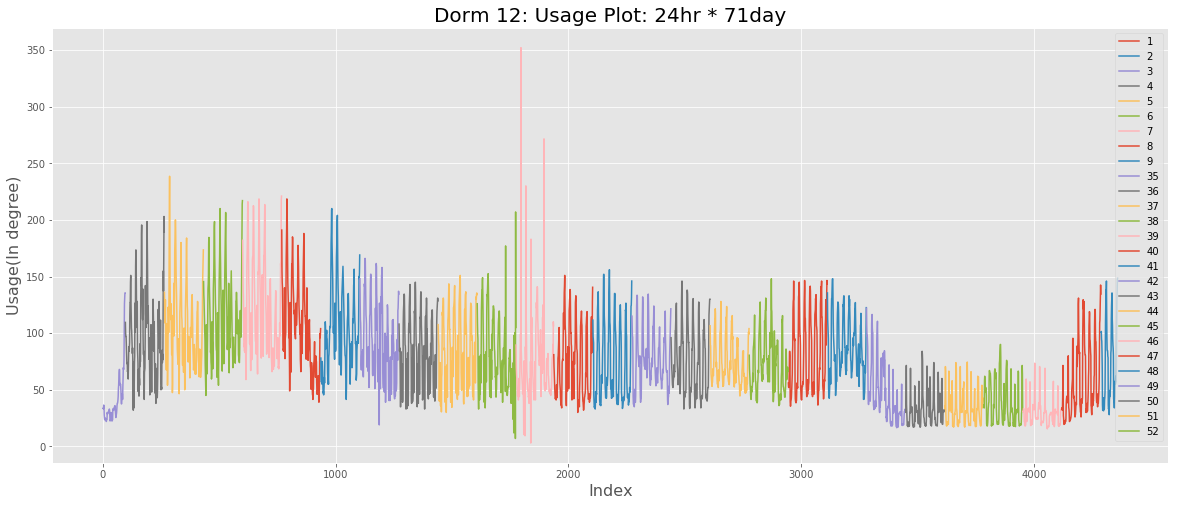

In [43]:
# 71 天每小時的用電資料 (1704個點)

# (df_dorm_12.Weekday * 30).plot(legend = True)
# plt.xlabel('index')

df_dorm_12.groupby(['Week']).Usage.plot(legend = True)
#.Usage.plot(legend = True)
plt.title('Dorm 12: Usage Plot: 24hr * 71day', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Index',fontsize = 16)


In [42]:
# df_dorm_12.sort_values('Cost').plot()

### 圖二：最高日用電 
討論極端值的成因

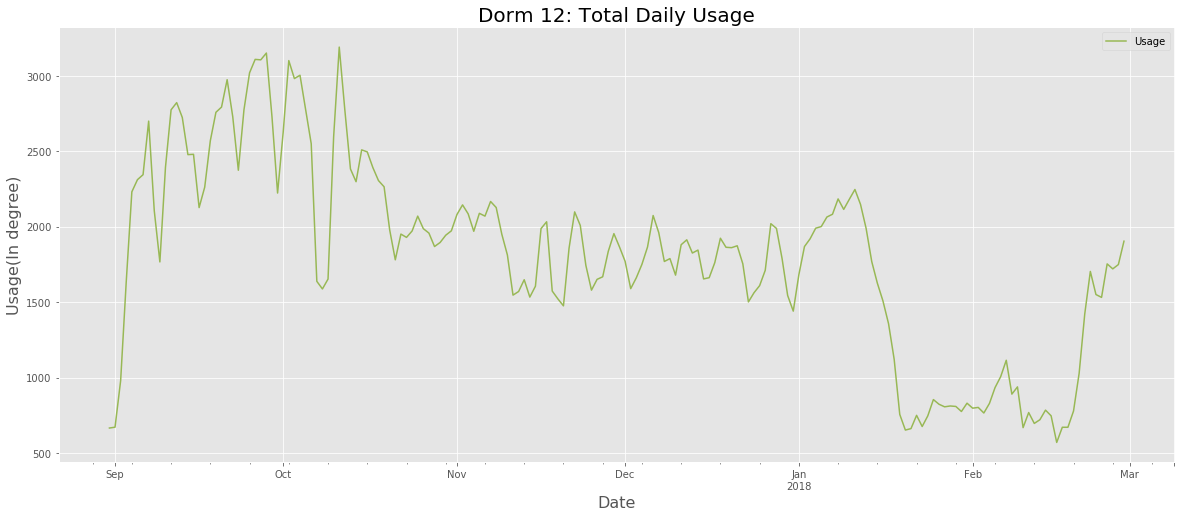

In [47]:
df_dorm_12_dailysum = df_dorm_12.groupby('Date').sum()
df_dorm_12_dailysum.Weekday = df_dorm_12_dailysum.Weekday/24
df_dorm_12_dailysum.Usage.plot.line(legend = True,color = cGreen)
plt.title('Dorm 12: Total Daily Usage', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Date',fontsize = 16)

In [49]:
# 最高用電的幾天是...
# 為什麼這幾天會比較高呢？
print('Top 10 daily TOTAL use of dorm 12. From 9.01 - 11.10')
print(df_dorm_12_dailysum.sort_values('Usage')[-10:])
# print('Top 10 daily AVERAGE use of dorm 12. From 9.01 - 11.10')
# print(df_dorm_12_dailymean_sorted[-10:])

Top 10 daily TOTAL use of dorm 12. From 9.01 - 11.10
            Unnamed: 0   Usage  Weekday  Week  Cost(2.8)    Cost
Date                                                            
2017-09-12        7188  2821.5      2.0   888     7900.2  6771.6
2017-09-21       12372  2973.5      4.0   912     8325.8  7136.4
2017-10-03       19284  2981.0      2.0   960     8346.8  7154.4
2017-10-04       19860  3003.0      3.0   960     8408.4  7207.2
2017-09-25       14676  3019.0      1.0   936     8453.2  7245.6
2017-10-02       18708  3100.0      1.0   960     8680.0  7440.0
2017-09-27       15828  3105.0      3.0   936     8694.0  7452.0
2017-09-26       15252  3108.0      2.0   936     8702.4  7459.2
2017-09-28       16404  3150.0      4.0   936     8820.0  7560.0
2017-10-11       23892  3189.5      3.0   984     8930.6  7654.8


觀察：其實最高用電的前十個日子，大多發生在九月十月，而且有連續的現象！

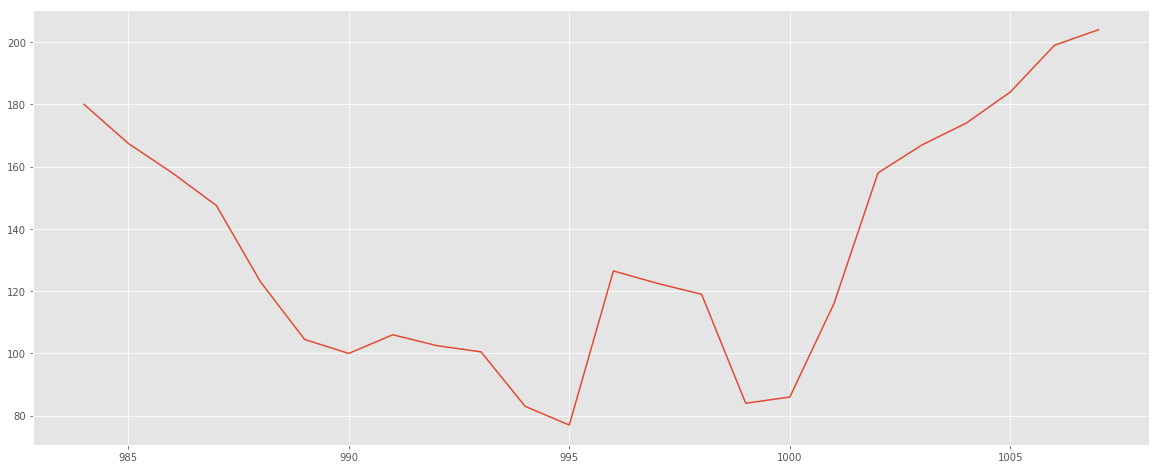

In [50]:
# 10.11 的用電繪圖
df_dorm_12[df_dorm_12.Date == '2017-10-11'].Usage.plot()
# xticks = list(df_dorm_12.Time.unique()) # bug to fix!!
# 不正常的地方：中午高峰

In [51]:
# 哪小時最耗電？
df_dorm_12.sort_values('Usage')[-100:].Time.value_counts()

22:00    26
23:00    24
21:00    19
00:00    13
20:00     9
19:00     4
01:00     3
06:00     1
03:00     1
Name: Time, dtype: int64

,Unnamed: 0,DateTime,Area,Building,Loop,Type,Usage,Date,Weekday,Time,Week,Cost(2.8),Cost
1796,1796,2017/11/13 23:00,S,D12,main,dorm,352.0,2017-11-13,1,23:00,46,985.6,844.8


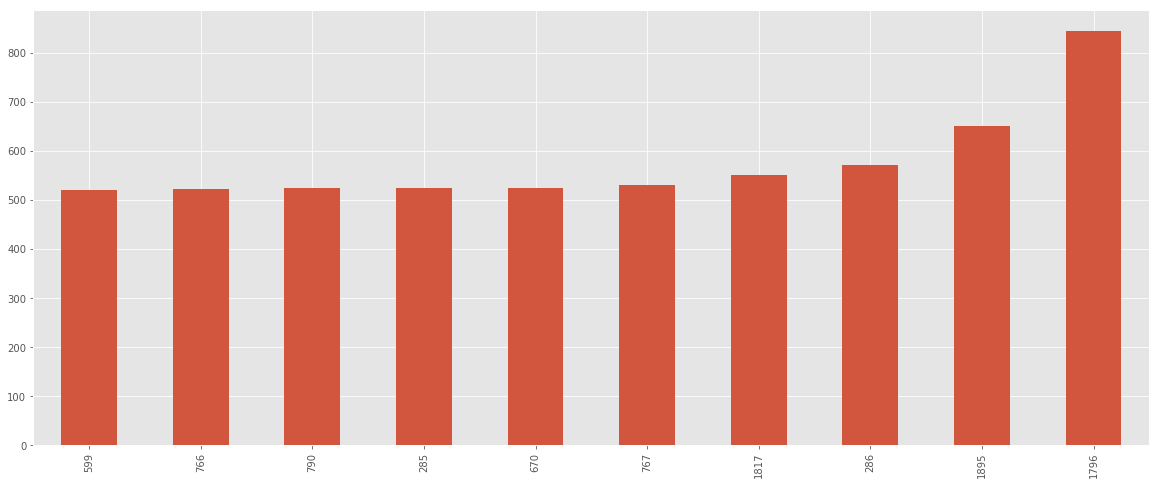

In [53]:
# Top 10 用電
# 看一下特高用電有多誇張，結果其實還好
df_dorm_12.sort_values('Usage')[-10:].Cost.plot.bar(color = cRed)
#發現有一小時真的特耗電

df_dorm_12.sort_values('Usage')[-1:]
# 2017/09/11 22:00 用電是 238.5, (12舍平均用電是96)

2017/9/11 為什麼用那麼多電呢？
我去查了日曆，原來是開學日的十點（一起打電動？煮火鍋？）

In [54]:
# 五十天中，星期幾最耗電？
df_dorm_12.groupby('Date').mean().sort_values('Usage')[-50:].Weekday.value_counts()

4.0    9
3.0    9
2.0    9
1.0    7
5.0    7
7.0    5
6.0    4
Name: Weekday, dtype: int64

### 圖三：平均用電變化 - 依Weekday看
#### 觀察
- 週六大家回家，平均用電最低
- 週日回宿舍，用電比週六週五高

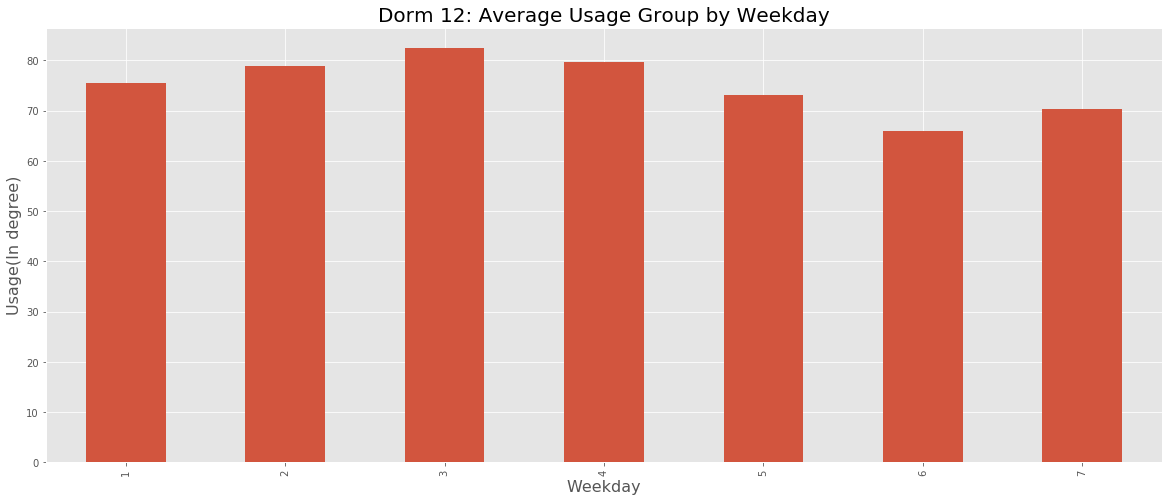

In [55]:
df_dorm_12_byWeekday = df_dorm_12.groupby('Weekday').mean()
df_dorm_12_byWeekday.Usage.plot.bar(legend = False,color = cRed)

plt.title('Dorm 12: Average Usage Group by Weekday', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Weekday',fontsize = 16)

### 圖三：各週用電變化 - 依Weekday看

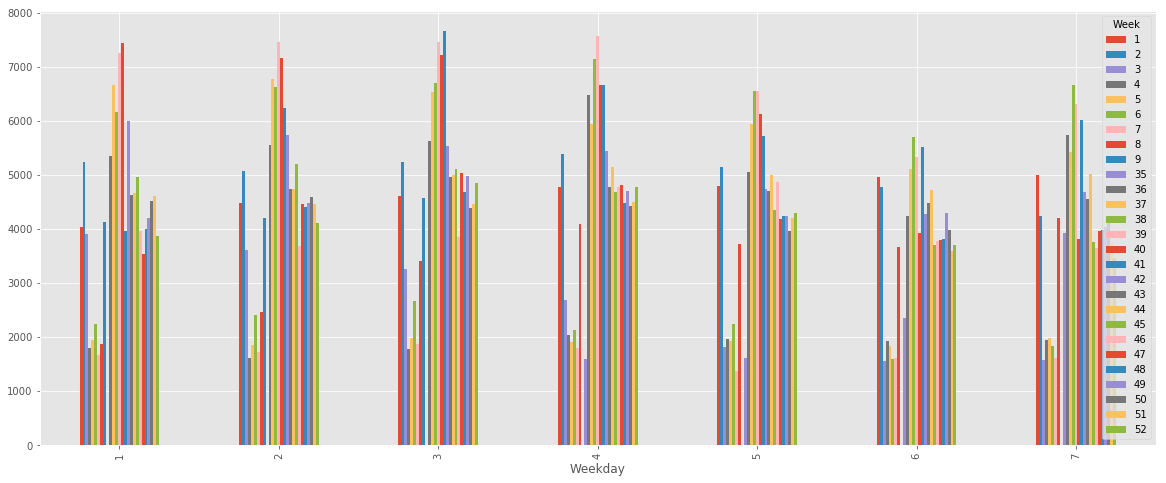

In [56]:
df_dorm_12.groupby(['Weekday','Week']).Cost.sum().unstack().plot.bar(legend = True)
#.Usage.plot(legend = True)
# 跟上一張圖的差別：可以看各周的變化

In [57]:
# 注意：取資料時，週五多一天
df_dorm_12.Weekday.value_counts()

7    624
3    624
5    624
4    624
2    623
1    622
6    620
Name: Weekday, dtype: int64

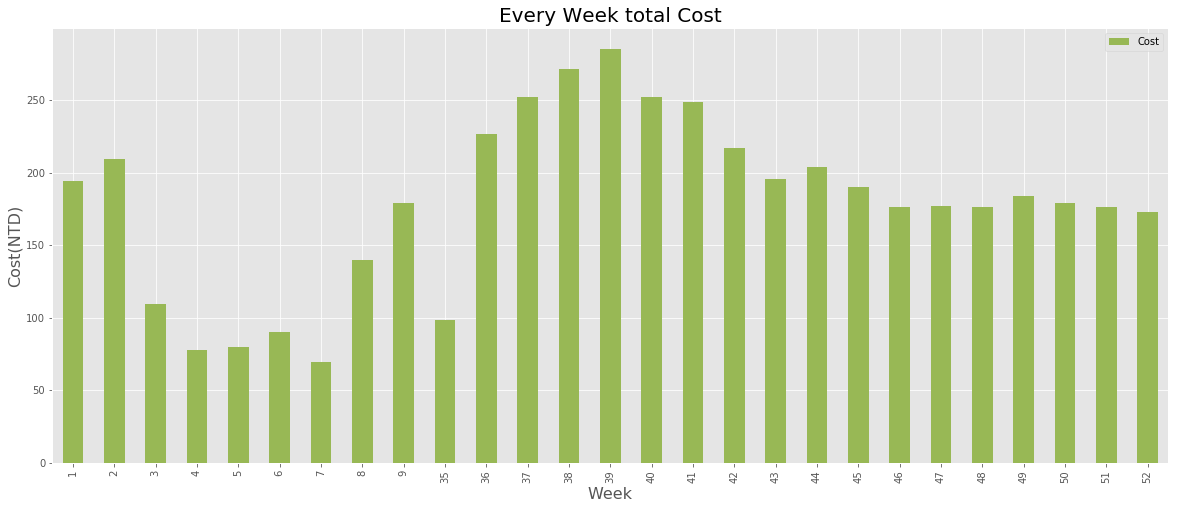

In [58]:
# df_dorm_12.groupby('Date').sum().Usage.plot.bar()
df_dorm_12.groupby('Week').mean().Cost.plot.bar(legend = True, color = cGreen)
plt.title('Every Week total Cost', fontsize = 20)
pylab.ylabel('Cost(NTD)',fontsize = 16)
pylab.xlabel('Week',fontsize = 16)

### 圖四：平均用電變化 - 依小時看

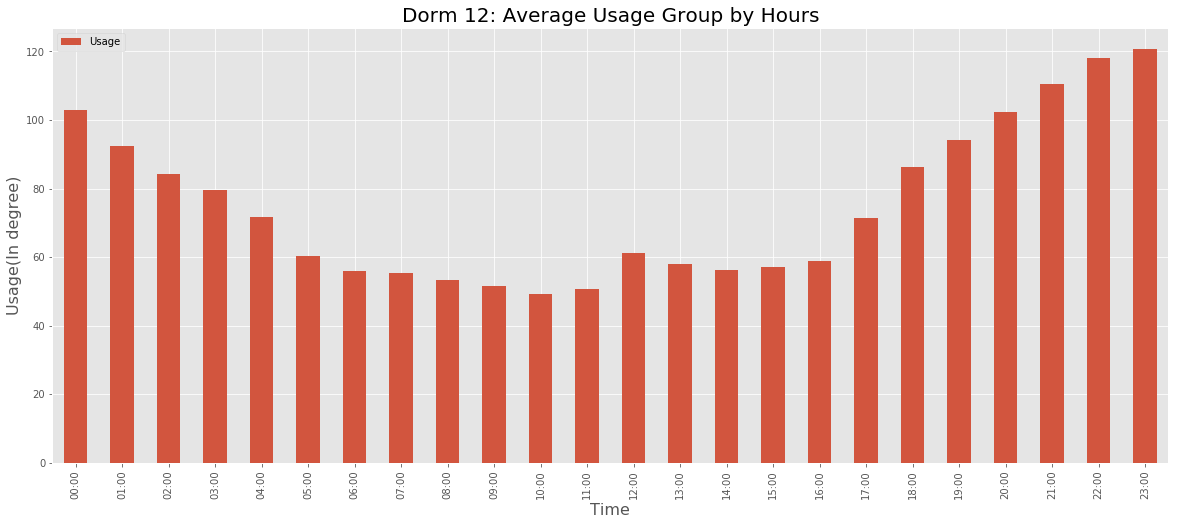

In [59]:
df_dorm_12.groupby('Time').Usage.mean().plot.bar(legend = True, color = cRed)
plt.title('Dorm 12: Average Usage Group by Hours', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Time',fontsize = 16)

### 觀察
- 這張是我覺得最有趣的，想法：可以拿去跟男生十舍比，看十二舍的人是不是比較早睡（省電）
- 最高用電落在晚上十一點到十二點。十二點會關燈。
- 關燈之後的下跌應該就是人為用電的減少（去睡覺了），人為用電除了桌電、吹風機以外，不知道洗澡熱水器有沒有被算在內？
- 早上七點起床有個Peak，可能是洗澡或開燈
- 中午十二點也有Peak，可能是回宿舍吃中飯
- 晚上六點開燈，所以用電升幅大

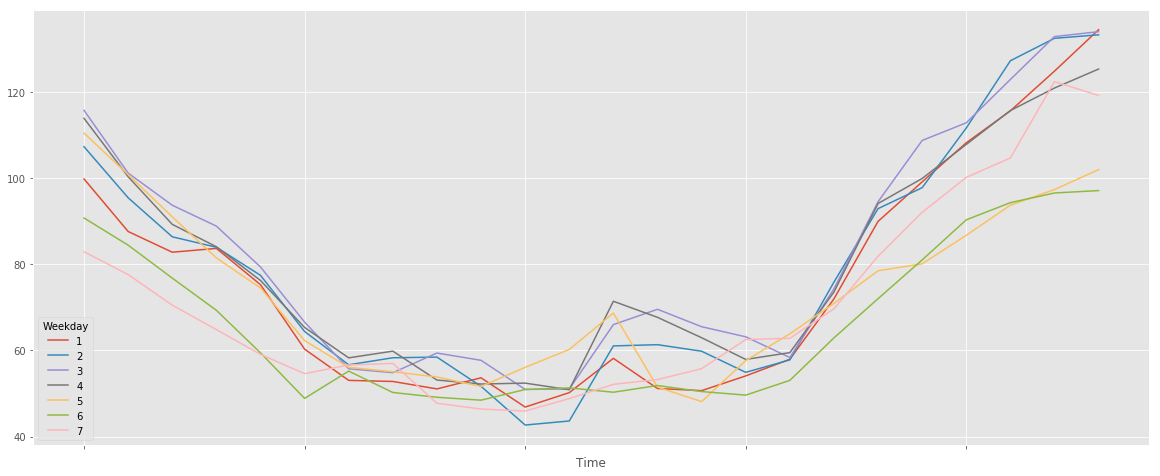

In [60]:
df_dorm_12.groupby(['Time','Weekday']).Usage.mean().unstack().plot(legend = True)
#.Usage.plot(legend = True)

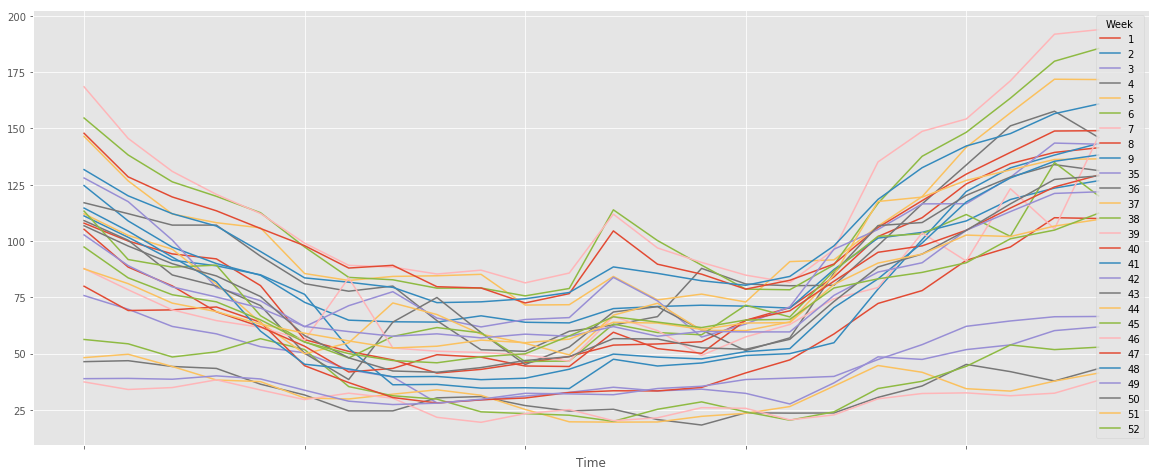

In [61]:
df_dorm_12.groupby(['Time','Week']).Usage.mean().unstack().plot(legend = True)
#.Usage.plot(legend = True)

### 圖七：每周在某一個時刻的用電變化 

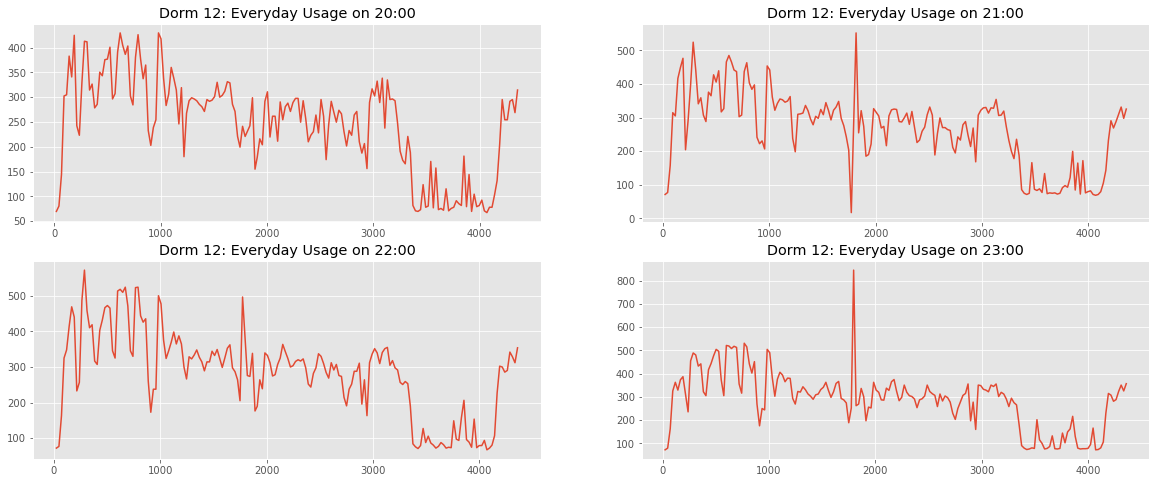

In [62]:
# 觀看某一個小時的用電量，在每天的變化

# df_dorm_12[df_dorm_12.Time == '23:00'].info()
fig, axes = plt.subplots(nrows=2, ncols=2)
df_dorm_12[df_dorm_12.Time == '20:00'].Cost.plot(ax=axes[0,0],title = 'Dorm 12: Everyday Usage on 20:00')
df_dorm_12[df_dorm_12.Time == '21:00'].Cost.plot(ax=axes[0,1],title = 'Dorm 12: Everyday Usage on 21:00')
df_dorm_12[df_dorm_12.Time == '22:00'].Cost.plot(ax=axes[1,0],title = 'Dorm 12: Everyday Usage on 22:00')
df_dorm_12[df_dorm_12.Time == '23:00'].Cost.plot(ax=axes[1,1],title = 'Dorm 12: Everyday Usage on 23:00')

## 成長率

In [63]:
# 使用 .pct_change()
df_dorm_12.groupby(['Week','Weekday']).mean().Cost.pct_change()[-20:]

Week  Weekday
50    2          0.017287
      3         -0.045752
      4          0.010685
      5         -0.103551
      6          0.004838
      7          0.060187
51    1          0.091683
      2         -0.031201
      3         -0.001342
      4          0.006719
      5         -0.063801
      6         -0.143998
      7          0.040640
52    1          0.030090
      2          0.063083
      3          0.180649
      4         -0.015598
      5         -0.100101
      6         -0.137228
      7         -0.067055
Name: Cost, dtype: float64

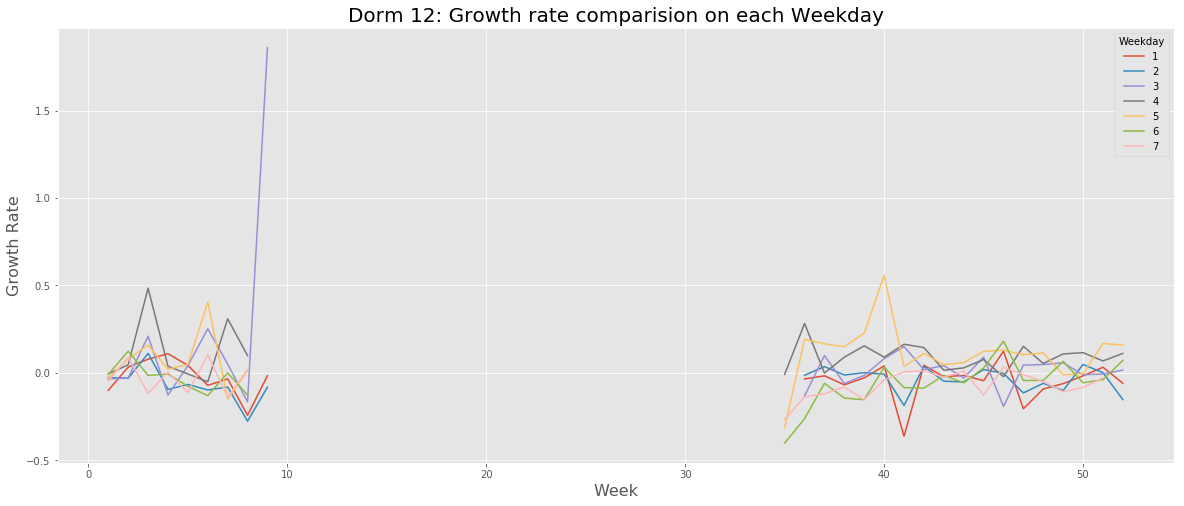

In [64]:
df_dorm_12.groupby(['Week','Weekday']).mean().Cost.pct_change(-1).unstack().plot()
plt.title('Dorm 12: Growth rate comparision on each Weekday', fontsize = 20)
pylab.ylabel('Growth Rate',fontsize = 16)
pylab.xlabel('Week',fontsize = 16) 

In [65]:
#探討peak的成因
df_dorm_12.groupby(['Week','Weekday']).mean().Cost.pct_change(-1).sort_values()[-10:]


Week  Weekday
3     3          0.209541
39    5          0.227447
6     3          0.252247
36    4          0.282185
7     4          0.309649
6     5          0.404192
3     4          0.484447
40    5          0.556947
9     3          1.860255
52    7               NaN
Name: Cost, dtype: float64

                Unnamed: 0       Usage  Week   Cost(2.8)        Cost
Time  Weekday                                                       
00:00 1        2191.923077   99.807692  30.5  279.461538  239.538462
      2        2215.846154  107.288462  30.5  300.407692  257.492308
      3        2239.807692  115.730769  30.5  324.046154  277.753846
      4        2096.076923  113.884615  31.5  318.876923  273.323077
      5        2120.076923  110.442308  31.5  309.238462  265.061538
      6        2144.076923   90.750000  31.5  254.100000  217.800000
      7        2167.923077   82.903846  31.5  232.130769  198.969231
01:00 1        2192.923077   87.615385  30.5  245.323077  210.276923
      2        2216.846154   95.442308  30.5  267.238462  229.061538
      3        2240.807692  101.173077  30.5  283.284615  242.815385
               Unnamed: 0     Usage      Week  Cost(2.8)      Cost
Time  Weekday                                                     
00:00 1         -0.010796 -0.069726  0

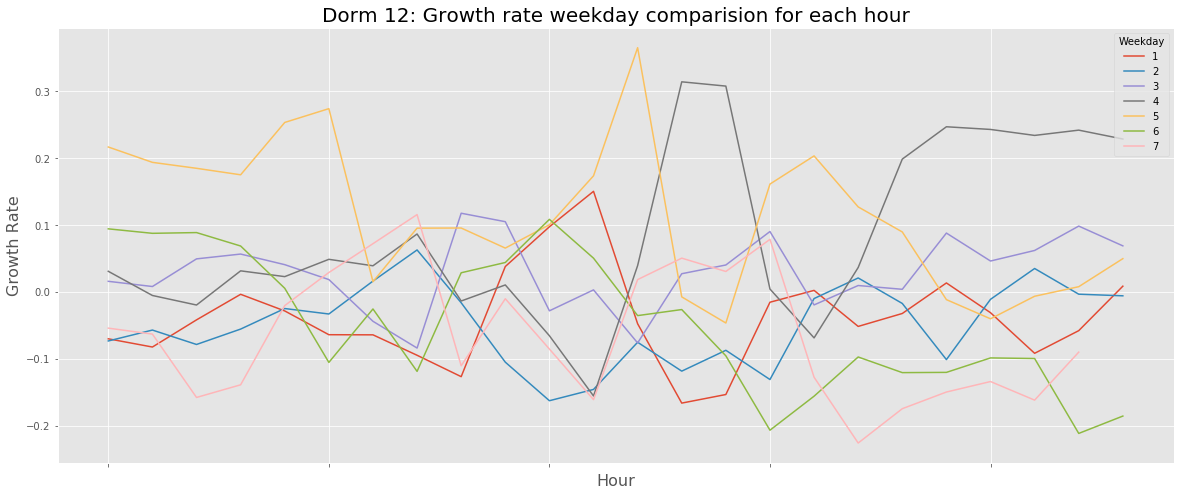

In [66]:
print(df_dorm_12.groupby(['Time','Weekday']).mean()[:10])
print(df_dorm_12.groupby(['Time','Weekday']).mean().pct_change(-1)[:10])
df_dorm_12.groupby(['Time','Weekday']).mean().Cost.pct_change(-1).unstack().plot()
plt.title('Dorm 12: Growth rate weekday comparision for each hour', fontsize = 20)
pylab.ylabel('Growth Rate',fontsize = 16)
pylab.xlabel('Hour',fontsize = 16) 

## 白天 / 晚上用電比率

In [67]:
# df_dorm_12.groupby(['Time','Weekday])
# df_dorm_12_night = df_dorm_12[((df_dorm_12.Time == '03:00') or (df_dorm_12.Time == '04:00') or (df_dorm_12.Time == '05:00'))]
df_dorm_12_night = df_dorm_12.loc[df_dorm_12['Time'].isin(['03:00', '04:00', '05:00', '06:00'])]
df_dorm_12_day = df_dorm_12.loc[df_dorm_12['Time'].isin(['07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00'])]
df_dorm_12_night = df_dorm_12_night.groupby('Date').mean()# 夜晚用電
df_dorm_12_day = df_dorm_12_day.groupby('Date').mean()
(df_dorm_12_day/df_dorm_12_night).head()

,Unnamed: 0,Usage,Weekday,Week,Cost(2.8),Cost
Date,,,,,,
2017-08-31,2.777778,0.780000,1.0,1.0,0.780000,0.780000
2017-09-01,1.280702,0.866667,1.0,1.0,0.866667,0.866667
2017-09-02,1.152381,1.097063,1.0,1.0,1.097063,1.097063
2017-09-03,1.104575,1.098039,1.0,1.0,1.098039,1.098039
2017-09-04,1.079602,0.885174,1.0,1.0,0.885174,0.885174


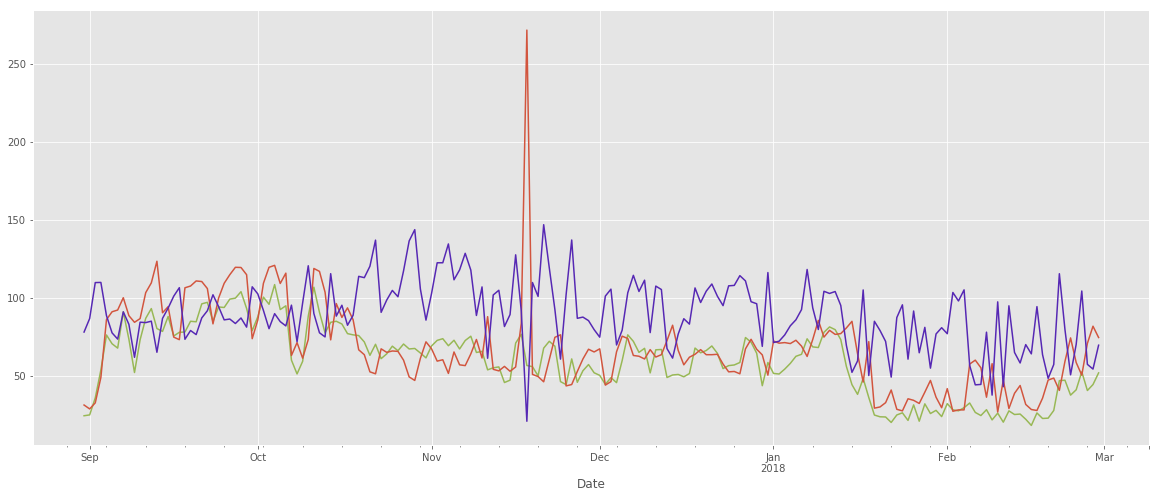

In [68]:
df_dorm_12_day.Usage.plot(color = cGreen)
df_dorm_12_night.Usage.plot(color = cRed)
((df_dorm_12_day/df_dorm_12_night).Usage*100).plot(color = cPurple) 
# bug ： 如何把兩個不同scale的圖畫再一起
# bug ： 如何畫線